In [15]:
import pandas as pd
import csv
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from nltk import word_tokenize     
import nltk
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer 
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multiclass import OneVsRestClassifier
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from nltk.corpus import stopwords
from gensim.models import Word2Vec
from sklearn.neural_network import MLPClassifier
from gensim.models import KeyedVectors
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import confusion_matrix, f1_score
import matplotlib.pyplot as plt
import keras.backend
from keras.layers import Dropout
from keras.callbacks import Callback
from sklearn.metrics import confusion_matrix, jaccard_similarity_score, accuracy_score, \
		f1_score, precision_score, recall_score

In [16]:
class Metrics(Callback):
    def __init__(self, x_test, y_test):
        self.x_test = x_test
        self.y_test = y_test

    def on_train_begin(self, logs={}):
        self.val_f1s = []
        self.val_recalls = []
        self.val_precisions = []
        self.val_accuracies = []
        self.val_jaccards = []

    def on_batch_end(self, batch, logs={}):
        pass

    def on_epoch_end(self, epoch, logs={}):
        val_predict = (np.asarray(self.model.predict(self.x_test)))

        print(val_predict)

        val_predict[val_predict >= 0.5] = 1
        val_predict[val_predict < 0.5] = 0
        print(self.y_test.columns)
        print("*****")
        print(val_predict)
        print("*****")
        print(self.y_test.values)
        print("*****")
        _val_f1 = f1_score(self.y_test.values, val_predict, average='weighted')
        _val_recall = recall_score(self.y_test.values, val_predict, average='weighted')
        _val_precision = precision_score(self.y_test.values, val_predict, average='weighted')
        _val_accuracy = accuracy_score(self.y_test.values, val_predict)
        _val_jaccard = jaccard_similarity_score(self.y_test.values, val_predict)

        self.val_f1s.append(_val_f1)
        self.val_recalls.append(_val_recall)
        self.val_precisions.append(_val_precision)
        self.val_accuracies.append(_val_accuracy)
        self.val_jaccards.append(_val_jaccard)

        print("— val_f1: {} — val_precision: {} — val_recall {} — val_accuracy: {} — val_jaccard {}" \
                .format(_val_f1, _val_precision, _val_recall, _val_accuracy, _val_jaccard))

        return

In [17]:
def load_data(subset = None):
    data = pd.read_csv("./dataset_20000.csv")
    if subset is not None:
        return data.head(subset)
    return data

In [18]:
def build_rnn(num_words, input_length):
    from keras.models import Sequential
    from keras.layers import Dense
    from keras.layers import LSTM
    from keras.layers.embeddings import Embedding
    from keras.preprocessing import sequence

    np.random.seed(7)

    embed_dim = 128
    lstm_out = 200

    model = Sequential()
    model.add(Embedding(num_words, embed_dim, input_length=input_length, dropout=0.2))
    model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(14, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [19]:
word_dict = set()
def remove_stopwords(sent):
	tokens = nltk.word_tokenize(sent)
	new_sent = []

	for token in tokens:
		word = token.lower()
		if word not in stop_words and len(token) > 2:
			if word not in word_dict:
				word_dict.add(word)

			new_sent.append(word)

	return new_sent

In [20]:
stop_words = set(stopwords.words('english'))

In [21]:
dataset = load_data(subset = 5000)
x = dataset["summary"]
y = dataset.drop(["summary"], axis=1)

In [22]:
X = [remove_stopwords(sent) for sent in x.values]
tokenizer = Tokenizer(filters='"#$%&()*+,-./:;<=>?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(X)
X = tokenizer.texts_to_sequences(X)
# X = tokenizer.sequences_to_matrix(X, mode='tfidf')
X = pad_sequences(X)

In [23]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2)
print(X_train)

[[    0     0     0 ...    19   602   924]
 [    0     0     0 ... 17773  1384  1616]
 [    0     0     0 ... 11175 12739  3348]
 ...
 [    0     0     0 ...  1195  9016    49]
 [    0     0     0 ...  4066  5714  3064]
 [    0     0     0 ... 19067  4840 21945]]


In [24]:
print(len(X_train[0]))
for x in X_train[0]:
    print(x)

2193
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0

In [25]:
metrics = Metrics(X_test, Y_test)
model = build_rnn(len(word_dict) + 1, X.shape[1])

/Users/jleoirab/.PYTHON_VIRTUALENVS/movieEnv/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: The `dropout` argument is no longer support in `Embedding`. You can apply a `keras.layers.SpatialDropout1D` layer right after the `Embedding` layer to get the same behavior.
  


In [26]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 2193, 128)         6515200   
_________________________________________________________________
lstm_2 (LSTM)                (None, 200)               263200    
_________________________________________________________________
dense_2 (Dense)              (None, 14)                2814      
Total params: 6,781,214
Trainable params: 6,781,214
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
h = model.fit(X_train, Y_train, batch_size=32, epochs=500, verbose=5, callbacks=[metrics])

Epoch 1/500
[[0.37395546 0.3665243  0.15902413 ... 0.08669884 0.05331417 0.05000805]
 [0.37423036 0.36639354 0.16062172 ... 0.08616456 0.05257863 0.04970327]
 [0.37141177 0.36793825 0.16080256 ... 0.0862313  0.05289274 0.04982789]
 ...
 [0.372202   0.36424774 0.1609233  ... 0.08702059 0.05330143 0.05007263]
 [0.3713948  0.36441377 0.16147596 ... 0.08734056 0.05310932 0.04996962]
 [0.37852392 0.37229353 0.16135795 ... 0.08661311 0.05301004 0.04997171]]
Index(['Drama', 'Comedy', 'Thriller', 'Romance Film', 'Action', 'Horror',
       'Crime Fiction', 'Adventure', 'Science Fiction', 'Animation',
       'Romantic comedy', 'Mystery', 'Crime Thriller', 'Fantasy'],
      dtype='object')
*****
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
*****
[[0 0 0 ... 0 0 0]
 [1 1 0 ... 0 0 0]
 [1 0 0 ... 0 0 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]]
*****
— val_f1: 0.0 — va

/Users/jleoirab/.PYTHON_VIRTUALENVS/movieEnv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/jleoirab/.PYTHON_VIRTUALENVS/movieEnv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[[0.4972801  0.34394506 0.17911373 ... 0.05499079 0.05372898 0.04520558]
 [0.51742715 0.34970933 0.18283011 ... 0.05535961 0.05316303 0.04435231]
 [0.47871444 0.38239372 0.17719474 ... 0.05404831 0.05397349 0.04700061]
 ...
 [0.52047294 0.3467229  0.18438655 ... 0.05661568 0.054406   0.04510774]
 [0.5028602  0.3411603  0.1841409  ... 0.0559503  0.05385597 0.04472951]
 [0.5189305  0.3891487  0.17999776 ... 0.05533183 0.05348258 0.04566383]]
Index(['Drama', 'Comedy', 'Thriller', 'Romance Film', 'Action', 'Horror',
       'Crime Fiction', 'Adventure', 'Science Fiction', 'Animation',
       'Romantic comedy', 'Mystery', 'Crime Thriller', 'Fantasy'],
      dtype='object')
*****
[[0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]
*****
[[0 0 0 ... 0 0 0]
 [1 1 0 ... 0 0 0]
 [1 0 0 ... 0 0 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]]
*****
— val_f1: 0.11730472227774041 

[[2.0130914e-04 2.4598013e-04 6.9546916e-02 ... 1.5692582e-02
  1.0242444e-03 9.7800477e-04]
 [3.7371350e-04 1.4872978e-03 2.9681159e-02 ... 2.9840525e-02
  4.9360638e-04 4.7876436e-04]
 [3.2403667e-03 4.5107752e-02 1.7780701e-04 ... 2.5667096e-04
  2.2092692e-05 2.0622689e-02]
 ...
 [8.3668578e-01 4.1682424e-06 1.8194232e-02 ... 2.7251574e-03
  1.5290752e-04 2.0241579e-03]
 [8.0363566e-01 7.2920837e-02 2.7838000e-04 ... 4.5238016e-03
  6.7970177e-05 4.9056410e-04]
 [1.2760723e-03 8.9403760e-01 1.8267404e-01 ... 4.2092755e-02
  7.0577342e-04 8.3562394e-04]]
Index(['Drama', 'Comedy', 'Thriller', 'Romance Film', 'Action', 'Horror',
       'Crime Fiction', 'Adventure', 'Science Fiction', 'Animation',
       'Romantic comedy', 'Mystery', 'Crime Thriller', 'Fantasy'],
      dtype='object')
*****
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]]
*****
[[0 0 0 ... 0 0 0]
 [1 1 0 ... 0 0 0

[[1.5185506e-06 8.7790002e-05 1.7639123e-01 ... 4.4995351e-03
  6.9503942e-05 2.4348227e-04]
 [2.7821476e-05 1.6289877e-03 5.1867422e-02 ... 2.9478863e-02
  6.7862733e-05 2.1878812e-05]
 [2.6386627e-04 5.2994811e-03 2.6561398e-05 ... 1.2929634e-05
  6.3646189e-07 1.6483777e-03]
 ...
 [9.4043028e-01 2.6483582e-07 6.3116825e-04 ... 6.1989049e-05
  2.3244297e-06 2.6038575e-03]
 [7.9600275e-01 1.4702557e-02 3.0084830e-04 ... 2.3259991e-03
  3.6871133e-06 3.6555009e-06]
 [7.0010632e-05 2.3950593e-01 3.8459271e-01 ... 1.2170926e-03
  3.7914553e-05 1.2841041e-04]]
Index(['Drama', 'Comedy', 'Thriller', 'Romance Film', 'Action', 'Horror',
       'Crime Fiction', 'Adventure', 'Science Fiction', 'Animation',
       'Romantic comedy', 'Mystery', 'Crime Thriller', 'Fantasy'],
      dtype='object')
*****
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
*****
[[0 0 0 ... 0 0 0]
 [1 1 0 ... 0 0 0

[[3.2369641e-07 1.9615996e-05 6.6518404e-02 ... 3.2048391e-03
  5.6158797e-06 3.3633816e-05]
 [6.5562431e-06 7.3349747e-06 1.1324960e-01 ... 2.1237271e-02
  2.5175817e-05 2.1479225e-06]
 [2.6663371e-05 1.3855522e-02 9.2030950e-06 ... 5.2495152e-06
  6.6930085e-07 2.8169521e-03]
 ...
 [8.2799393e-01 1.1473848e-08 2.6324083e-04 ... 1.8175486e-05
  5.9727944e-07 2.8750147e-03]
 [7.9437125e-01 4.4634588e-02 4.0332146e-05 ... 3.3099442e-03
  9.5375526e-07 2.7611013e-06]
 [2.8613231e-05 8.0437303e-02 4.1587508e-01 ... 1.7195351e-03
  4.1242174e-06 1.3370232e-05]]
Index(['Drama', 'Comedy', 'Thriller', 'Romance Film', 'Action', 'Horror',
       'Crime Fiction', 'Adventure', 'Science Fiction', 'Animation',
       'Romantic comedy', 'Mystery', 'Crime Thriller', 'Fantasy'],
      dtype='object')
*****
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
*****
[[0 0 0 ... 0 0 0]
 [1 1 0 ... 0 0 0

[[9.6118640e-08 4.4331068e-06 3.5176846e-01 ... 6.1415083e-04
  1.9471454e-06 4.9253686e-06]
 [9.9300439e-07 1.2597404e-05 2.5502000e-02 ... 1.2763982e-02
  1.4008093e-05 5.7887446e-06]
 [2.5419526e-05 3.5648534e-04 4.7058393e-06 ... 1.8833258e-06
  2.6974699e-06 3.2411721e-03]
 ...
 [8.7283403e-01 7.8893425e-09 1.6188272e-04 ... 1.5657159e-05
  9.6988765e-07 5.1387455e-03]
 [4.7002324e-01 5.5703189e-02 4.8870599e-05 ... 5.4222685e-03
  2.2584065e-06 2.0018902e-07]
 [4.5726516e-05 1.7903784e-01 8.2971108e-01 ... 5.2095036e-04
  1.9000649e-05 4.0239538e-06]]
Index(['Drama', 'Comedy', 'Thriller', 'Romance Film', 'Action', 'Horror',
       'Crime Fiction', 'Adventure', 'Science Fiction', 'Animation',
       'Romantic comedy', 'Mystery', 'Crime Thriller', 'Fantasy'],
      dtype='object')
*****
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]]
*****
[[0 0 0 ... 0 0 0]
 [1 1 0 ... 0 0 0

[[6.4934248e-08 5.3344256e-06 3.6148487e-03 ... 3.1666517e-05
  4.8103095e-07 1.0111605e-04]
 [7.0384834e-07 6.1362378e-05 1.0756802e-02 ... 2.5030950e-02
  3.1463213e-05 2.3797586e-05]
 [7.7077220e-06 1.9707205e-02 2.8448223e-06 ... 2.7095466e-06
  3.5518769e-06 4.3791625e-01]
 ...
 [6.8896365e-01 1.1990250e-08 2.0479118e-05 ... 3.2781230e-05
  1.8532295e-06 9.9693472e-03]
 [4.1226479e-01 2.6870696e-02 3.5198950e-04 ... 3.6714678e-03
  3.2822038e-06 2.7033519e-07]
 [7.4987202e-06 7.7388860e-02 1.6836558e-01 ... 1.6445607e-03
  9.2244463e-06 5.4715194e-05]]
Index(['Drama', 'Comedy', 'Thriller', 'Romance Film', 'Action', 'Horror',
       'Crime Fiction', 'Adventure', 'Science Fiction', 'Animation',
       'Romantic comedy', 'Mystery', 'Crime Thriller', 'Fantasy'],
      dtype='object')
*****
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
*****
[[0 0 0 ... 0 0 0]
 [1 1 0 ... 0 0 0

[[1.3169523e-07 2.0492789e-06 2.3199015e-04 ... 4.9212467e-05
  6.4299530e-07 7.6211518e-06]
 [1.3385313e-06 1.0958473e-05 2.8716279e-03 ... 1.0015844e-02
  4.7420996e-05 2.4511332e-06]
 [3.0650444e-05 1.0155003e-03 1.2692429e-07 ... 1.2823299e-06
  4.1009048e-06 9.1896042e-02]
 ...
 [6.3680249e-01 2.4032976e-09 8.3790360e-07 ... 4.0780160e-06
  3.4749351e-07 9.9559792e-04]
 [1.4150858e-01 2.8784522e-03 2.5642541e-06 ... 1.3014830e-04
  1.1770796e-07 4.1849766e-08]
 [3.0145815e-04 2.9693010e-01 2.3981031e-04 ... 2.5791755e-06
  3.1098793e-06 1.1488989e-06]]
Index(['Drama', 'Comedy', 'Thriller', 'Romance Film', 'Action', 'Horror',
       'Crime Fiction', 'Adventure', 'Science Fiction', 'Animation',
       'Romantic comedy', 'Mystery', 'Crime Thriller', 'Fantasy'],
      dtype='object')
*****
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
*****
[[0 0 0 ... 0 0 0]
 [1 1 0 ... 0 0 0

[[7.0702759e-09 2.1695371e-06 8.3587309e-03 ... 7.6623503e-05
  2.2371078e-06 1.2032344e-06]
 [5.8481612e-07 2.2980328e-05 1.9653554e-03 ... 6.0151829e-03
  2.1608275e-05 1.8073086e-06]
 [4.3430016e-05 1.7985539e-04 3.4188455e-05 ... 3.9677320e-07
  1.1540521e-05 4.8044031e-03]
 ...
 [2.1429297e-01 3.0299279e-09 8.0178870e-07 ... 1.9850515e-06
  3.9391266e-06 8.5436064e-04]
 [2.9343328e-01 4.1314503e-03 3.0783817e-04 ... 2.5161158e-03
  2.1671217e-06 1.3415162e-07]
 [3.8884766e-05 2.3476794e-01 6.7173680e-03 ... 1.1234015e-05
  1.6479684e-06 8.0081213e-07]]
Index(['Drama', 'Comedy', 'Thriller', 'Romance Film', 'Action', 'Horror',
       'Crime Fiction', 'Adventure', 'Science Fiction', 'Animation',
       'Romantic comedy', 'Mystery', 'Crime Thriller', 'Fantasy'],
      dtype='object')
*****
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
*****
[[0 0 0 ... 0 0 0]
 [1 1 0 ... 0 0 0

[[5.6759162e-09 1.3626862e-05 2.9731167e-03 ... 5.1640734e-05
  3.3813239e-07 2.4424008e-07]
 [8.8225357e-07 2.6625551e-06 3.9747378e-05 ... 3.3727649e-03
  1.7369632e-06 8.8379913e-08]
 [7.9827523e-06 1.7326422e-05 6.3124816e-07 ... 4.9395606e-08
  1.3735039e-06 1.8908228e-04]
 ...
 [2.0926771e-01 8.6147467e-10 5.9568045e-08 ... 3.9193824e-06
  5.1474717e-07 4.8142010e-03]
 [4.4823308e-02 3.8878500e-02 3.0011115e-05 ... 1.5557923e-03
  1.6312019e-07 1.8707201e-08]
 [7.5726297e-07 2.1056314e-01 7.2739919e-04 ... 2.0460432e-06
  3.2433357e-07 1.9693340e-07]]
Index(['Drama', 'Comedy', 'Thriller', 'Romance Film', 'Action', 'Horror',
       'Crime Fiction', 'Adventure', 'Science Fiction', 'Animation',
       'Romantic comedy', 'Mystery', 'Crime Thriller', 'Fantasy'],
      dtype='object')
*****
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
*****
[[0 0 0 ... 0 0 0]
 [1 1 0 ... 0 0 0

[[2.7807854e-08 4.9133133e-04 3.7726637e-02 ... 1.1659724e-04
  6.6385560e-08 2.3547941e-06]
 [3.5772975e-06 1.5150576e-05 3.7473070e-03 ... 3.8156290e-02
  1.2786706e-05 7.7598370e-06]
 [9.1027748e-03 1.2417791e-03 1.8660187e-04 ... 2.5221934e-07
  6.1666515e-06 2.5619587e-03]
 ...
 [9.6769172e-01 7.4776008e-10 1.8064857e-05 ... 6.6610382e-06
  6.8310595e-07 9.8388866e-03]
 [8.0633885e-01 4.3421715e-02 1.5982769e-03 ... 2.3075669e-01
  1.2705616e-05 9.4072035e-08]
 [1.2940070e-05 6.3735038e-01 1.8480355e-02 ... 7.1831164e-06
  2.2361917e-07 1.2462426e-05]]
Index(['Drama', 'Comedy', 'Thriller', 'Romance Film', 'Action', 'Horror',
       'Crime Fiction', 'Adventure', 'Science Fiction', 'Animation',
       'Romantic comedy', 'Mystery', 'Crime Thriller', 'Fantasy'],
      dtype='object')
*****
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]]
*****
[[0 0 0 ... 0 0 0]
 [1 1 0 ... 0 0 0

[[7.48263784e-10 4.77629728e-05 3.40728797e-02 ... 4.73109649e-05
  1.66673132e-07 1.16953345e-07]
 [7.42126986e-07 1.17146901e-05 2.47883610e-04 ... 1.28585845e-02
  2.19153990e-05 7.11106679e-07]
 [2.95054706e-05 1.48090499e-03 1.54562565e-06 ... 1.16145394e-07
  3.66746417e-06 1.10090170e-02]
 ...
 [7.38696516e-01 1.24201982e-09 2.03050217e-06 ... 1.37528252e-06
  2.35722518e-06 2.03490420e-03]
 [5.15559971e-01 7.91655779e-02 2.57436826e-04 ... 1.26183592e-03
  1.96340608e-07 1.10948388e-08]
 [2.95289851e-06 9.29764435e-02 1.18425287e-01 ... 1.19639424e-06
  1.89961622e-06 4.49131932e-07]]
Index(['Drama', 'Comedy', 'Thriller', 'Romance Film', 'Action', 'Horror',
       'Crime Fiction', 'Adventure', 'Science Fiction', 'Animation',
       'Romantic comedy', 'Mystery', 'Crime Thriller', 'Fantasy'],
      dtype='object')
*****
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
*****


[[1.2773924e-09 1.5113283e-06 1.4990032e-01 ... 1.4415392e-05
  3.9503714e-08 4.6771103e-08]
 [1.2619148e-06 1.2878977e-06 6.6701825e-05 ... 8.9932065e-03
  1.5959320e-06 2.9991432e-07]
 [2.9495600e-04 7.9220543e-03 6.4796666e-07 ... 4.0208239e-08
  1.5550437e-06 6.5210682e-01]
 ...
 [4.9771169e-01 4.1902437e-10 4.3204216e-07 ... 2.0276962e-06
  1.7731383e-06 1.8648835e-02]
 [8.5610271e-01 7.5489217e-01 1.2316884e-05 ... 2.1155553e-03
  1.5598799e-07 8.3949265e-09]
 [7.0992965e-06 1.9698867e-01 3.3957385e-02 ... 3.5604364e-07
  2.2459504e-07 3.1111563e-07]]
Index(['Drama', 'Comedy', 'Thriller', 'Romance Film', 'Action', 'Horror',
       'Crime Fiction', 'Adventure', 'Science Fiction', 'Animation',
       'Romantic comedy', 'Mystery', 'Crime Thriller', 'Fantasy'],
      dtype='object')
*****
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [1. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
*****
[[0 0 0 ... 0 0 0]
 [1 1 0 ... 0 0 0

[[7.9538438e-09 7.6034579e-05 1.2417088e-02 ... 8.4029507e-06
  4.1630318e-07 1.0198571e-05]
 [1.6664959e-06 1.6272337e-05 2.9473553e-05 ... 1.5542292e-02
  6.2631254e-05 9.1329039e-06]
 [7.1572344e-05 4.6209809e-01 3.1574356e-07 ... 3.7616708e-08
  1.1049076e-05 1.6458364e-01]
 ...
 [5.0708028e-03 1.5153137e-08 8.0724632e-08 ... 3.8535027e-06
  8.3662244e-06 3.0332530e-01]
 [5.8720121e-03 4.9117088e-02 5.2345884e-05 ... 4.2644203e-02
  5.1949469e-06 3.0405758e-08]
 [2.4313200e-04 9.9986064e-01 1.0764202e-03 ... 1.8522969e-05
  4.8247034e-06 1.2890367e-06]]
Index(['Drama', 'Comedy', 'Thriller', 'Romance Film', 'Action', 'Horror',
       'Crime Fiction', 'Adventure', 'Science Fiction', 'Animation',
       'Romantic comedy', 'Mystery', 'Crime Thriller', 'Fantasy'],
      dtype='object')
*****
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]]
*****
[[0 0 0 ... 0 0 0]
 [1 1 0 ... 0 0 0

[[1.6094864e-09 5.1752548e-05 1.1731098e-02 ... 8.0632002e-05
  6.3285881e-08 4.8971586e-08]
 [3.1339955e-06 3.3541124e-05 8.4697676e-04 ... 1.1633291e-01
  7.0760965e-05 1.1144796e-06]
 [3.8827525e-06 4.9675533e-01 1.0740893e-05 ... 6.0570073e-08
  4.3696755e-06 4.4742767e-02]
 ...
 [9.7445583e-01 2.6259628e-09 6.2257841e-06 ... 9.5008545e-06
  1.4105953e-05 8.8755131e-02]
 [2.6019004e-03 8.1293219e-01 5.6914047e-05 ... 4.6443716e-03
  7.0710598e-07 2.8458436e-09]
 [1.0551284e-04 9.9569041e-01 1.7489708e-03 ... 2.5383923e-07
  1.1864704e-06 2.5729034e-07]]
Index(['Drama', 'Comedy', 'Thriller', 'Romance Film', 'Action', 'Horror',
       'Crime Fiction', 'Adventure', 'Science Fiction', 'Animation',
       'Romantic comedy', 'Mystery', 'Crime Thriller', 'Fantasy'],
      dtype='object')
*****
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]]
*****
[[0 0 0 ... 0 0 0]
 [1 1 0 ... 0 0 0

[[3.1735131e-10 2.0624268e-05 3.7948489e-03 ... 4.9173766e-05
  1.6876131e-08 5.5997624e-09]
 [8.6622897e-08 6.5338786e-06 1.2147654e-04 ... 2.5152129e-01
  2.7597311e-05 6.3728613e-08]
 [2.6093886e-07 1.9726384e-02 2.2814438e-06 ... 2.9403624e-08
  1.2262046e-06 1.6765183e-02]
 ...
 [1.8831937e-01 9.9636666e-10 4.9117847e-07 ... 7.4976615e-06
  4.7638218e-06 5.1193714e-02]
 [1.5815036e-02 9.3735808e-01 1.0596325e-04 ... 2.7426472e-03
  4.1490603e-07 1.0162237e-09]
 [2.4064191e-06 9.8279703e-01 1.2658251e-03 ... 9.6956249e-08
  4.1830381e-07 1.8364696e-08]]
Index(['Drama', 'Comedy', 'Thriller', 'Romance Film', 'Action', 'Horror',
       'Crime Fiction', 'Adventure', 'Science Fiction', 'Animation',
       'Romantic comedy', 'Mystery', 'Crime Thriller', 'Fantasy'],
      dtype='object')
*****
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]]
*****
[[0 0 0 ... 0 0 0]
 [1 1 0 ... 0 0 0

[[1.4400813e-09 1.3672518e-04 2.3142684e-03 ... 2.2254097e-05
  5.4861161e-08 4.6612051e-08]
 [1.4844178e-06 1.6564280e-06 7.3168128e-05 ... 1.3376865e-01
  6.6147069e-05 4.8697052e-07]
 [2.3820268e-05 1.6289367e-01 2.1749147e-06 ... 8.4650136e-09
  3.2560404e-06 1.3505978e-03]
 ...
 [8.3502418e-01 1.2193364e-08 6.4425058e-07 ... 1.0469735e-05
  3.5364744e-06 5.9065681e-02]
 [6.4871483e-02 9.2758095e-01 2.7532925e-04 ... 8.6049158e-03
  1.2742439e-06 2.1699202e-08]
 [5.4104341e-05 9.9468428e-01 8.8873263e-03 ... 2.1888718e-07
  9.5928044e-07 2.4650401e-08]]
Index(['Drama', 'Comedy', 'Thriller', 'Romance Film', 'Action', 'Horror',
       'Crime Fiction', 'Adventure', 'Science Fiction', 'Animation',
       'Romantic comedy', 'Mystery', 'Crime Thriller', 'Fantasy'],
      dtype='object')
*****
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]]
*****
[[0 0 0 ... 0 0 0]
 [1 1 0 ... 0 0 0

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1093, 128)         1947648   
_________________________________________________________________
lstm_1 (LSTM)                (None, 200)               263200    
_________________________________________________________________
dense_1 (Dense)              (None, 14)                2814      
Total params: 2,213,662
Trainable params: 2,213,662
Non-trainable params: 0
_________________________________________________________________
None
0.38074316024780275
0.8492857027053833


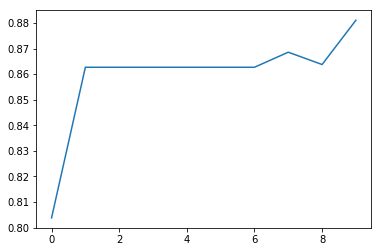

In [14]:
plt.plot(h.history['acc'])

print(model.summary())

score, acc = model.evaluate(X_test, Y_test, verbose=2, batch_size= 32)

print(score)
print(acc)